In [500]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from dateutil.relativedelta import relativedelta
from tqdm import tqdm

In [3]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 1000)

In [4]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [103]:
def output_to_accu(model, X, y):
    nb_errors = 0
    for b in range(0, X.size(0)):
        output = model(X.narrow(0, b, 1))
        _, predicted_classes = output.max(1)
        for k in range(1):
            if y[b + k, predicted_classes[k]] != 1.:
                nb_errors = nb_errors + 1
    accuracy = 100 * (1 - nb_errors / X.size(0))
    return accuracy

In [104]:
def output_to_loss(model, X, y):
    nb_errors = 0
    loss = 0
    criterion = nn.BCELoss()
    for b in range(0, X.size(0)):
        output = model(X.narrow(0, b, 1))
        loss += criterion(output, y.narrow(0, b, 1))
        
    return loss

In [5]:
indices_price_excel = pd.read_excel('SW_data/indices_price.xlsx', sheet_name='price', index_col=0, skiprows=[0,1,2,3,5,6,7])

In [458]:
bench_price = indices_price_excel['SPI Index'].asfreq('D', method='ffill')
price = indices_price_excel[indices_price_excel.columns[1:]].asfreq('D', method='ffill')
daily_returns = price.pct_change()
daily_return_bench = bench_price.pct_change()
price.head()

SMIMC Index  SMCI Index  SPIEX Index  SPI20 Index
1996-01-04       426.47     2049.35       423.28       3395.8
1996-01-05       426.04     2054.88       424.38       3376.1
1996-01-06       426.04     2054.88       424.38       3376.1
1996-01-07       426.04     2054.88       424.38       3376.1
1996-01-08       427.94     2071.98       427.67       3368.1

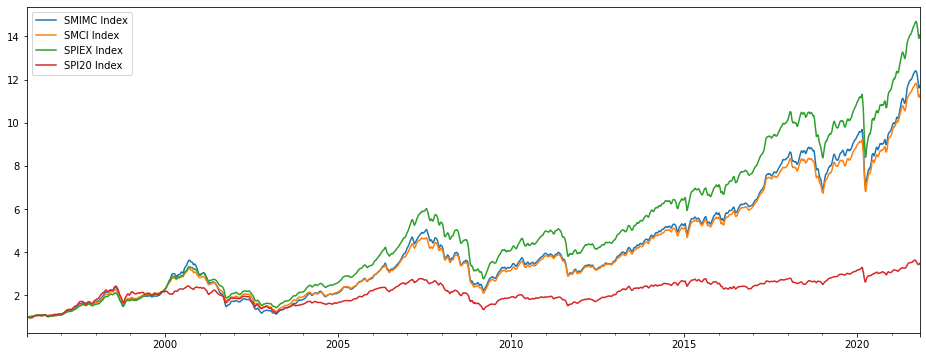

In [516]:
fig, ax = plt.subplots(figsize=(16,6))
(daily_returns + 1).cumprod().rolling(20).mean().plot(ax=ax)
plt.show()

In [459]:
mom12 = price.pct_change(periods=21 * 12)
mom6 = price.pct_change(periods=21 * 6)
mom1 = price.pct_change(periods=21 * 1)

ma200 = np.log(price / price.rolling(window=200).mean())
ma100 = np.log(price / price.rolling(window=100).mean())
ma50 = np.log(price / price.rolling(window=50).mean())

vol12 = price.rolling(window=21 * 12).std()
vol6 = price.rolling(window=21 * 6).std()
vol1 = price.rolling(window=21 * 1).std()

In [460]:
ema_12 = price.ewm(span=10).mean()
ema_26 = price.ewm(span=60).mean()
MACD = ema_12 - ema_26

In [461]:
def RSI(price, window):
    price_diff = price.diff()
    gain = price_diff.mask(price_diff < 0, 0.0)
    loss = - price_diff.mask(price_diff > 0, -0.0)
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    rs = avg_gain / avg_loss
    rsi = 1 - 1 / (1 + rs)
    return rsi

In [462]:
RSI14 = RSI(price, 14)
RSI9 = RSI(price, 9)
RSI3 = RSI(price, 3)

In [463]:
df_dict = {}
df_X = pd.DataFrame()
for col in price.columns:
    df_temp = pd.concat([ma50[col], ma100[col], ma200[col],
                         mom12[col], mom6[col], mom1[col],
                         vol12[col], vol6[col], vol1[col],
                         RSI14[col], RSI9[col], RSI3[col], 
                         MACD[col]], axis=1).asfreq('D', method='ffill').loc['1997-01-01':].fillna(method='ffill')
    df_temp.columns = ['ma50', 'ma100', 'ma200', 'mom12', 'mom6', 'mom1', 
                       'vol12', 'vol6', 'vol1', 'RSI14', 'RSI9', 'RSI3', 'MACD']
    df_dict[col] = df_temp
    
df_X = pd.concat(df_dict, axis=1)

In [464]:
df_X.head()

SMIMC Index                                                    \
                  ma50     ma100     ma200     mom12      mom6      mom1   
1997-01-01    0.014890  0.028585  0.045367  0.010506  0.075344  0.019856   
1997-01-02    0.014115  0.027852  0.045311  0.011880  0.083172  0.006702   
1997-01-03    0.024387  0.038145  0.056274  0.017091  0.085253  0.024929   
1997-01-04    0.023670  0.037469  0.056143  0.017091  0.085253  0.024929   
1997-01-05    0.022953  0.036752  0.056000  0.017091  0.085253  0.024929   

                                                                               \
                vol12       vol6      vol1     RSI14      RSI9 RSI3      MACD   
1997-01-01  13.719565  10.620504  2.162347  0.615010  0.978405  1.0  6.190702   
1997-01-02  13.744065  10.594086  2.318069  0.832454  1.000000  1.0  6.350959   
1997-01-03  13.788874  10.691504  2.958671  0.898156  1.000000  1.0  7.231276   
1997-01-04  13.833463  10.779621  3.388369  0.898156  1.000000  1.0  7.884812   
1997-01-05  13.877834  10.858662  3.681764  0.898156  1.000000  1.0  8.354988   

           SMCI Index                                                    \
                 ma50     ma100     ma200     mom12      mom6      mom1   
1997-01-01   0.016542  0.028523  0.043469  0.022806  0.059253  0.018812   
1997-01-02   0.015814  0.027907  0.043290  0.025663  0.061989  0.012682   
1997-01-03   0.019494  0.031651  0.047446  0.020537  0.066345  0.020078   
1997-01-04   0.018922  0.031064  0.047253  0.020537  0.066345  0.020078   
1997-01-05   0.018351  0.030481  0.047059  0.020537  0.066345  0.020078   

                                                                            \
                vol12       vol6       vol1     RSI14 RSI9 RSI3       MACD   
1997-01-01  47.984405  41.541541  11.184891  0.904803  1.0  1.0  32.111086   
1997-01-02  48.278193  41.841704  11.879759  0.909276  1.0  1.0  32.591935   
1997-01-03  48.571762  42.273342  12.893541  0.912335  1.0  1.0  34.262517   
1997-01-04  48.862882  42.670494  13.479862  0.912335  1.0  1.0  35.380295   
1997-01-05  49.151597  43.034114  13.693742  0.912335  1.0  1.0  36.053943   

           SPIEX Index                                                    \
                  ma50     ma100     ma200     mom12      mom6      mom1   
1997-01-01    0.012731  0.023844  0.035974  0.018865  0.051314  0.016044   
1997-01-02    0.012116  0.023314  0.035867  0.020046  0.053429  0.011041   
1997-01-03    0.012516  0.023703  0.036648  0.013051  0.052451  0.015167   
1997-01-04    0.012105  0.023237  0.036539  0.013051  0.052451  0.015167   
1997-01-05    0.011694  0.022772  0.036426  0.013051  0.052451  0.015167   

                                                                             \
               vol12      vol6      vol1     RSI14      RSI9 RSI3      MACD   
1997-01-01  8.783314  7.628690  1.956667  0.812865  0.849088  1.0  4.820640   
1997-01-02  8.826825  7.673586  2.164066  0.884224  1.000000  1.0  5.030273   
1997-01-03  8.860569  7.727818  2.300195  0.867540  1.000000  1.0  5.228772   
1997-01-04  8.894121  7.777260  2.380605  0.867540  1.000000  1.0  5.354686   
1997-01-05  8.927482  7.822003  2.410876  0.867540  1.000000  1.0  5.422408   

           SPI20 Index                                                    \
                  ma50     ma100     ma200     mom12      mom6      mom1   
1997-01-01    0.015337  0.029673  0.050574  0.074637  0.067595  0.021931   
1997-01-02    0.014737  0.028939  0.050109  0.074725  0.070494  0.021295   
1997-01-03    0.013774  0.027773  0.049123  0.066044  0.080575  0.026255   
1997-01-04    0.013557  0.027146  0.048707  0.066044  0.080575  0.026255   
1997-01-05    0.013340  0.026511  0.048312  0.066044  0.080575  0.026255   

                                                                            \
                 vol12       vol6       vol1     RSI14      RSI9      RSI3   
1997-01-01  115.067084  87.412133  34.653116  0.781818  0.869

In [617]:
monthly_return = price.pct_change().resample('M').agg(lambda x: (x + 1).prod() - 1)
best_pred = monthly_return.rank(axis=1).replace({1: 0., 2: 0., 3: 1., 4: 1.}).shift(-1).loc['1997-01-31':]
best_pred_one = monthly_return.rank(axis=1).replace({1: 0., 2: 0., 3: 0., 4: 1.}).shift(-1).loc['1997-01-31':]
best_pred.head()

SMIMC Index  SMCI Index  SPIEX Index  SPI20 Index
1997-01-31          1.0         0.0          0.0          1.0
1997-02-28          0.0         0.0          1.0          1.0
1997-03-31          1.0         0.0          0.0          1.0
1997-04-30          1.0         1.0          0.0          0.0
1997-05-31          1.0         0.0          0.0          1.0

In [523]:
df_input.head()

SMIMC Index                                                    \
                  ma50     ma100     ma200     mom12      mom6      mom1   
2015-12-01    0.040965  0.070044  0.071521  0.055434  0.071076  0.041199   
2015-12-02    0.038454  0.067792  0.070307  0.065615  0.059982  0.030140   
2015-12-03    0.028446  0.058424  0.061612  0.064662  0.046020  0.029252   
2015-12-04    0.019727  0.050072  0.054051  0.061374  0.032434  0.025674   
2015-12-05    0.018473  0.049291  0.053884  0.061374  0.032434  0.025674   

                                                                           \
                vol12       vol6       vol1     RSI14      RSI9      RSI3   
2015-12-01  64.865117  79.418030  30.954254  0.759124  0.713208  1.000000   
2015-12-02  65.706314  80.684013  32.852999  0.721017  0.724064  0.935835   
2015-12-03  66.336429  81.584253  32.111067  0.597694  0.761730  0.392458   
2015-12-04  66.800749  82.193448  29.722433  0.510249  0.494907  0.000000   
2015-12-05  67.257025  82.793500  26.783496  0.510249  0.470641  0.000000   

                      SMCI Index                                          \
                 MACD       ma50     ma100     ma200     mom12      mom6   
2015-12-01  73.412752   0.037028  0.061822  0.059171  0.043225  0.052891   
2015-12-02  75.485246   0.036365  0.061439  0.059764  0.053666  0.045619   
2015-12-03  73.527799   0.027580  0.053333  0.052277  0.053547  0.034543   
2015-12-04  68.814662   0.020452  0.046664  0.046322  0.051924  0.023534   
2015-12-05  64.674670   0.019249  0.045995  0.046213  0.051924  0.023534   

                                                                              \
                mom1       vol12        vol6        vol1     RSI14      RSI9   
2015-12-01  0.035981  270.910547  329.542302  127.073032  0.739826  0.697717   
2015-12-02  0.028435  273.968183  334.540900  137.705437  0.724194  0.735671   
2015-12-03  0.028889  276.247376  338.040308  135.988322  0.612949  0.800611   
2015-12-04  0.026373  277.947062  340.361244  126.776098  0.535587  0.591611   
2015-12-05  0.026373  279.618106  342.653440  115.037430  0.535587  0.559194   

                                 SPIEX Index                                \
                RSI3        MACD        ma50     ma100     ma200     mom12   
2015-12-01  1.000000  292.794297    0.035404  0.058473  0.055137  0.043659   
2015-12-02  1.000000  306.236465    0.034649  0.057996  0.055589  0.053255   
2015-12-03  0.480879  302.404641    0.026388  0.050397  0.048582  0.052794   
2015-12-04  0.059817  287.562141    0.019678  0.044143  0.043008  0.051062   
2015-12-05  0.000000  274.102206    0.018520  0.043520  0.042914  0.051062   

                                                                           \
                mom6      mom1      vol12       vol6       vol1     RSI14   
2015-12-01  0.048780  0.034289  66.959390  81.435902  31.384871  0.744577   
2015-12-02  0.042153  0.027150  67.698109  82.651979  33.969349  0.728282   
2015-12-03  0.031855  0.027745  68.238846  83.501969  33.451931  0.613976   
2015-12-04  0.021267  0.024719  68.634687  84.057355  31.221953  0.538028   
2015-12-05  0.021267  0.024719  69.023352  84.606142  28.380183  0.538028   

                                          SPI20 Index                      \
                RSI9      RSI3       MACD        ma50     ma100     ma200   
2015-12-01  0.704061  1.000000  72.712816    0.013280  0.025516  0.001749   
2015-12-02  0.740166  1.000000  75.979971    0.015055  0.027481  0.004391   
2015-12-03  0.799807  0.468526  75.017139   -0.003977  0.008971 -0.013869   
2015-12-04  0.599138  0.051478  71.356435   -0.009892  0.003102 -0.019229   
2015-12-05  0.565846  0.000000  68.034140   -0.010088  0.003113 -0.018954   

                                                                              \
               mom12      mom6      mom1       vol12        vol6        vol1   
2015-12-01 -0.032223 -0.030454  0.016212  277.114427  287

In [524]:
df_output.head()

SMIMC Index  SMCI Index  SPIEX Index  SPI20 Index
2015-12-31          1.0         0.0          1.0          0.0
2016-01-31          0.0         1.0          1.0          0.0
2016-02-29          0.0         1.0          1.0          0.0
2016-03-31          0.0         0.0          1.0          1.0
2016-04-30          1.0         1.0          0.0          0.0

In [694]:
def pred_to_perf(df_pred, tax=0.):
    first_date = df_pred.index[0]
    last_date = df_pred.index[-1]
    daily_ret = daily_returns[first_date:last_date].asfreq('D', method='ffill')
    df_pred_daily = df_pred.reindex(daily_ret.index, method='ffill').shift(1)
    df_perf = (df_pred_daily * daily_ret).sum(axis=1)
    df_cost = (df_pred_daily.diff().fillna(0) != 0).any(axis=1).astype(int) * tax
    return (1 + df_perf - df_cost).cumprod()

In [740]:
def turnover(df_pred):
    daily_ret = daily_returns[first_date:last_date].asfreq('D', method='ffill')
    df_pred_daily = df_pred.reindex(daily_ret.index, method='ffill').shift(1)
    return (df_pred_daily.diff().fillna(0) != 0).any(axis=1).astype(int).sum().sum()

In [695]:
def price_to_perf(df):
    df = df.asfreq('D', method='ffill')
    return (1 + df.pct_change().fillna(0)).cumprod()

In [696]:
def perf_to_stat(perf):
    year_group = perf.resample('Y')
    average_year_return = ((year_group.last() - year_group.first()) / year_group.first()).mean() * 100
    average_year_std = year_group.std().mean() * 100
    average_year_sharpe = average_year_return / average_year_std
    
    dd_window = 252
    roll_max = perf.rolling(dd_window).max()
    daily_dd = perf / roll_max - 1
    max_daily_dd = np.abs(daily_dd.rolling(dd_window, min_periods=1).min()).max() * 100

    return average_year_return, average_year_std, average_year_sharpe, max_daily_dd

In [697]:
class MLP(nn.Module):
    def __init__(self, x1, x2, x3, pdrop=0.1):
        super().__init__()
        self.fc1 = nn.Linear(x1 * x2 * x3, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 4)
        self.drop = nn.Dropout(pdrop)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.flatten(start_dim=1)
        x = self.relu(self.drop(self.fc1(x)))
        x = self.relu(self.drop(self.fc2(x)))
        x = self.relu(self.drop(self.fc3(x)))
        x = self.fc4(x)
        x = self.sigmoid(x)
        
        return x

In [698]:
class ConvNet(nn.Module):
    def __init__(self, x1, x2, x3, pdrop=0.01):
        super().__init__()
        
        
        self.conv1 = nn.Conv3d(1, 16, kernel_size=(2, 2, x3))
        # 16 x (x1 - 1) x (x2 - 1) x (x3 - (x3-1)) = 16 x 3 x 3 x 1
        
        self.conv2 = nn.Conv3d(16, 32, kernel_size=(2, 2, 1))
        # 16 x (3 - 1) x (3 - 1) x 1 = 32 x 2 x 2
        
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, 4)
        
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
        self.drop = nn.Dropout(pdrop)
        self.drop2d = nn.Dropout2d(pdrop)

    def forward(self, x):
        
        x = x.view(x.size(0), 1, x.size(1), x.size(2), x.size(3))
    
        x = self.relu(self.drop2d(self.conv1(x)))
        x = self.relu(self.drop2d(self.conv2(x)))
        
        #print(x.shape)
        x = x.flatten(start_dim=1)

        x = self.relu(self.drop(self.fc1(x)))
        # x = self.relu(self.drop(self.fc2(x)))
        x = self.sigmoid(self.fc2(x))

        return x

In [ ]:
X_train.shape

In [752]:
class LSTM(nn.Module):

    def __init__(self, input_size, output_size, hidden_size=5, num_layers=2, dropout=0):
        super(LSTM, self).__init__()
        
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
        
    def forward(self, x):
        h0 = torch.randn(num_layers, x.size(0), hidden_size)
        c0 = torch.randn(num_layers, x.size(0), hidden_size)
        x = x.view(x.size(0), x.size(1), x.size(2) * x.size(3))
        x, _ = self.lstm(x, (h0, c0))
        x = self.relu(x)
        x = self.sigmoid(self.fc(x[:, -1, :]))
        
        return x

In [751]:
X_train.narrow(0, b, mini_batch_size).shape

torch.Size([1, 4, 4, 13])

2002-01-31 00:00:00
epoch 1 : 2.459087446331978
epoch 6 : 1.9346416145563126
epoch 11 : 1.9297302141785622
epoch 16 : 1.9272910356521606
epoch 21 : 1.820109412074089
epoch 26 : 1.6360001489520073
epoch 31 : 1.6288049891591072
epoch 36 : 1.4779778867959976
epoch 41 : 1.4655644819140434
epoch 46 : 1.7333084139972925
epoch 51 : 1.5654814168810844
epoch 56 : 1.4534290842711926
epoch 61 : 1.551538098603487
epoch 66 : 1.4138544090092182
epoch 71 : 1.4790361411869526
epoch 76 : 1.4488431960344315
epoch 81 : 1.3605142869055271
epoch 86 : 1.3279649782925844
epoch 91 : 1.2471907548606396
epoch 96 : 1.2190850675106049
epoch 101 : 1.4115952774882317
epoch 106 : 1.2660251129418612
epoch 111 : 1.3254189249128103
epoch 116 : 1.3967123618349433
epoch 121 : 1.3499910905957222
epoch 126 : 1.343570638448
epoch 131 : 1.3740957044064999
epoch 136 : 1.2612414164468646
epoch 141 : 1.185345171019435
epoch 146 : 1.2272389587014914
epoch 151 : 1.2002804451622069
epoch 156 : 1.2218178533948958
epoch 161 : 1.1351

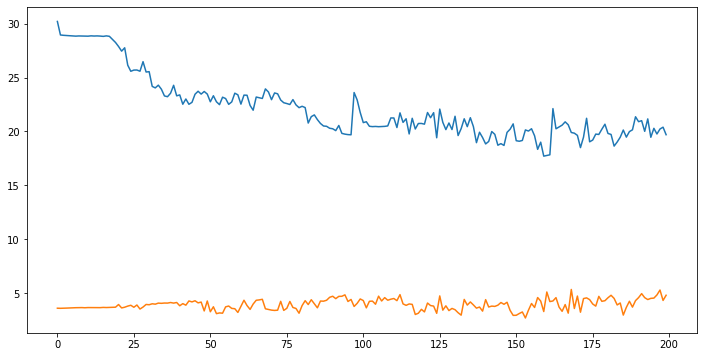

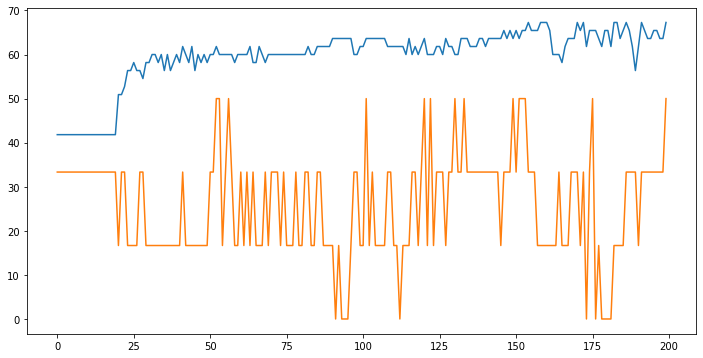

2002-07-31 00:00:00
epoch 1 : 2.3981351107358932
epoch 6 : 1.9679144620895386
epoch 11 : 1.969149500131607
epoch 16 : 1.9689268916845322
epoch 21 : 1.9608063846826553
epoch 26 : 1.9416242837905884
epoch 31 : 1.8862473294138908
epoch 36 : 1.7121167480945587
epoch 41 : 1.6491769030690193
epoch 46 : 1.4516610577702522
epoch 51 : 1.4178708530962467
epoch 56 : 1.3829622436314821
epoch 61 : 1.385486138984561
epoch 66 : 1.3712149066850543
epoch 71 : 1.3839064668864012
epoch 76 : 1.5106846280395985
epoch 81 : 1.4092566091567278
epoch 86 : 1.3083867244422436
epoch 91 : 1.25064860843122
epoch 96 : 1.305198752321303
epoch 101 : 1.1385692562907934
epoch 106 : 1.2524090204387903
epoch 111 : 1.0944075575098395
epoch 116 : 1.084993396885693
epoch 121 : 1.2525852993130684
epoch 126 : 1.004441300407052
epoch 131 : 1.0827097138389945
epoch 136 : 0.9826212557964027
epoch 141 : 0.9776914096437395
epoch 146 : 1.0440849526785314
epoch 151 : 1.025280668400228
epoch 156 : 1.0425622477196157
epoch 161 : 0.9576

In [ ]:
first_end_date = '2002-01-01'
input_period = 4
num_tickers = 4
num_features = 13
pdrop=0.2
eta = 1e-2
mini_batch_size = 5
hidden_size = 5
num_layers = 5

nb_epochs = 200

prob_output = []
pred_output = []
all_end_dates = best_pred.loc[first_end_date:].asfreq('6M', method='ffill').index
for i, end_date in enumerate(all_end_dates[:2]):
    print(end_date)
    # Data
    start_date = end_date - relativedelta(years=5)
    start_date_input = start_date.replace(day=1)    
    df_input = df_X.loc[start_date_input:end_date]
    df_output = best_pred_one.loc[start_date:end_date] # best_pred // best_pred_one
    
    X = []
    for idx in df_output.index:
        df_input_period = df_input.loc[:idx].asfreq('W', method='ffill').iloc[-input_period:]
        X_period = df_input_period.values.reshape(num_tickers, input_period, num_features).transpose(1,0,2)
        X.append(X_period)
    X = np.array(X)
    y = df_output.values
    
    if i == 0:
        #first_start_date_test = end_date.replace(day=31, month=1)
        first_start_date_test = end_date - relativedelta(months=5)
     
    # start_date_test = end_date.replace(day=31, month=1)
    start_date_test = end_date - relativedelta(months=5)
    split_index = df_output.index.get_loc(start_date_test)    
    X_train, y_train = X[:split_index], y[:split_index]
    X_test, y_test = X[split_index:], y[split_index:]
    
    X_train, y_train, X_test, y_test = torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float(), torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float()

    train_mean = X_train.mean(dim=[0,1,2], keepdim=True)
    train_std = X_train.std(dim=[0,1,2], keepdim=True)
    X_train = X_train.sub_(train_mean).div_(train_std)
    
    #print(df_output[split_index:])   
    
    #train_size = X_train.size(0)
    #shuffle_idx = torch.randperm(train_size)
    #X_train = X_train[shuffle_idx, :, :]
    #y_train = y_train[shuffle_idx, :]
                      
    test_mean = X_test.mean(dim=[0,1,2], keepdim=True)
    test_std = X_test.std(dim=[0,1,2], keepdim=True)
    X_test = X_test.sub_(test_mean).div_(test_std)
    
    # Model
    dim1, dim2, dim3 = X_train.size(1), X_train.size(2), X_train.size(3)
    # model = MLP(dim1, dim2, dim3, pdrop)
    model = LSTM(input_size=num_tickers * num_features, output_size=num_tickers, hidden_size=hidden_size, num_layers=num_layers)
    #optimizer = torch.optim.Adam(model.parameters(), lr=eta)
    optimizer = torch.optim.RMSprop(model.parameters(), lr=eta)
    criterion = nn.BCELoss()
    #criterion = nn.MSELoss()
    
    train_accu_list = []
    train_loss_list = []
    test_accu_list = []
    test_loss_list = []
    for e in range(nb_epochs):
        acc_loss = 0
        model.train()
        for b in range(0, X_train.size(0), mini_batch_size):
            optimizer.zero_grad()
            output = model(X_train.narrow(0, b, mini_batch_size))
            loss = criterion(output, y_train.narrow(0, b, mini_batch_size))
            acc_loss = acc_loss + loss.item()
            loss.backward()
            optimizer.step()
            
        model.eval()
        train_accu = output_to_accu(model, X_train, y_train)
        train_accu_list.append(train_accu)
        test_accu = output_to_accu(model, X_test, y_test)
        test_accu_list.append(test_accu)

        train_loss = output_to_loss(model, X_train, y_train)
        train_loss_list.append(train_loss)
        test_loss = output_to_loss(model, X_test, y_test)
        test_loss_list.append(test_loss)

        if (e % 5) == 0:
            print('epoch', e + 1, ':', acc_loss)
            
    fig = plt.figure(figsize=(12,6))
    plt.plot(list(range(nb_epochs)), train_loss_list, label='Train loss')
    plt.plot(list(range(nb_epochs)), test_loss_list, label='Test loss')
    plt.show()
    fig = plt.figure(figsize=(12,6))
    plt.plot(list(range(nb_epochs)), train_accu_list, label='Train accuracy')
    plt.plot(list(range(nb_epochs)), test_accu_list, label='Test accuracy')
    plt.show()
    
    model.eval()
    pred = np.zeros((X_test.size(0), y_test.size(1)))
    for b in range(0, X_test.size(0)):
        output = model(X_test.narrow(0, b, 1))
        _, pred_index = output.max(1)
        pred[b, pred_index.item()] = 1
    prob_output.append(output)
    pred_output.append(pred)
    
pred_output = np.array(pred_output).reshape(len(all_end_dates) * X_test.size(0), y_test.size(1))
df_pred = pd.DataFrame(index=best_pred_test.index, data=pred_output, columns=best_pred.columns)

In [759]:
all_end_dates[0]

Timestamp('2002-01-31 00:00:00', freq='6M')

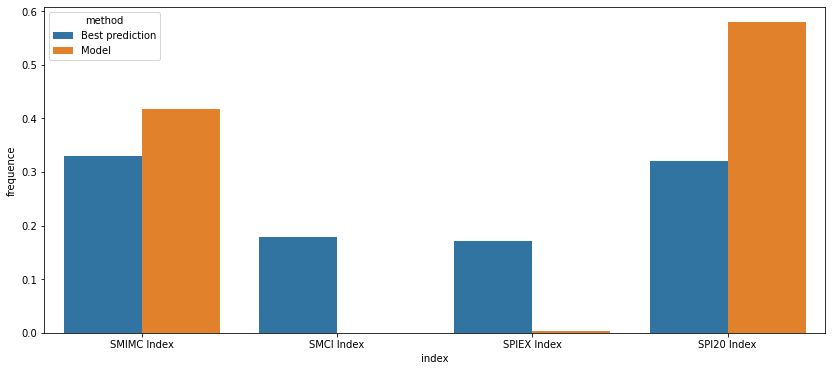

In [754]:
fig = plt.figure(figsize=(14,6))
df_results = pd.concat([best_pred_test_one.sum(axis=0) / len(best_pred_test_one), df_pred.sum(axis=0) / len(best_pred_test_one)], axis=1).rename(columns={0:'Best prediction', 1:'Model'})
df_results = df_results.reset_index()
df_results = df_results.melt(id_vars='index', var_name='method', value_name='frequence')
sns.barplot(data=df_results, x='index', y='frequence', hue='method')
plt.show()

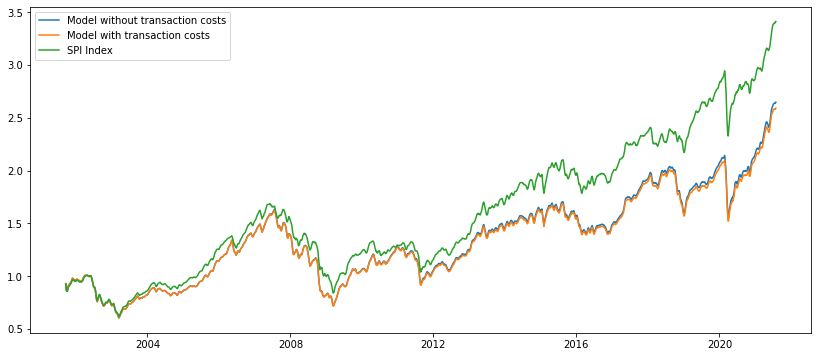

In [755]:
perf_pred_gross = pred_to_perf(df_pred, 0.).rename('Model without transaction costs')
perf_pred_net = pred_to_perf(df_pred, 0.0012).rename('Model with transaction costs')

data = pd.concat([perf_pred_gross, perf_pred_net, price_to_perf(bench_price[first_start_date_test:end_date])], axis=1)

fig = plt.figure(figsize=(14,6))        
sns.lineplot(data=data.rolling(20).mean(), dashes=False)
plt.show()

In [743]:
stats = np.array([perf_to_stat(perf_bench), perf_to_stat(perf_pred_gross)])
df_stats = pd.DataFrame(data=stats, columns=['Avg. annual return', 'Avg. annual vol.', 'Avg Sharpe ratio', 'Max. Drawdown'], index=['Benchmark SPI', 'Model']).round(2)
turnover_num = turnover(df_pred)
df_stats.at['Model', 'Turnover'] = turnover_num
df_stats

Avg. annual return  Avg. annual vol.  Avg Sharpe ratio  \
Benchmark SPI                7.59              8.86              0.86   
Model                        9.42             12.33              0.76   

               Max. Drawdown  Turnover  
Benchmark SPI          40.91       NaN  
Model                  47.16     139.0

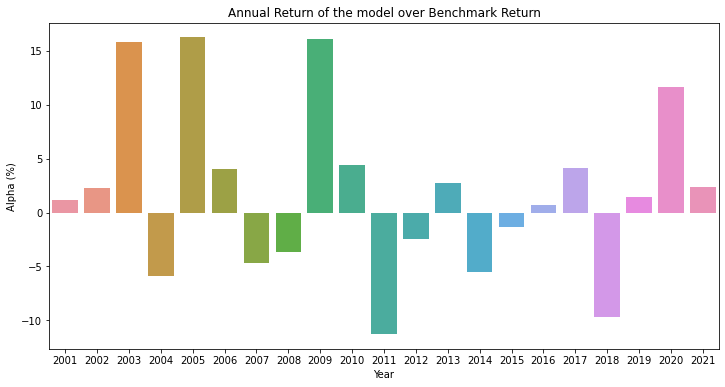

In [742]:
year_group_bench = perf_bench.resample('Y')
year_group_pred = perf_pred.resample('Y')
annual_returns_bench = (year_group_bench.last() - year_group_bench.first()) / year_group_bench.first()
annual_returns_pred = (year_group_pred.last() - year_group_pred.first()) / year_group_pred.first()
annual_diff = (annual_returns_pred - annual_returns_bench) * 100
df_annual_diff = pd.DataFrame(columns=['year', 'alpha'])
df_annual_diff['year'] = annual_diff.index.year
df_annual_diff['alpha'] = annual_diff.values

fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(data=df_annual_diff, x='year', y='alpha')
plt.ylabel('Alpha (%)')
plt.xlabel('Year')
plt.title('Annual Return of the model over Benchmark Return')
plt.show()

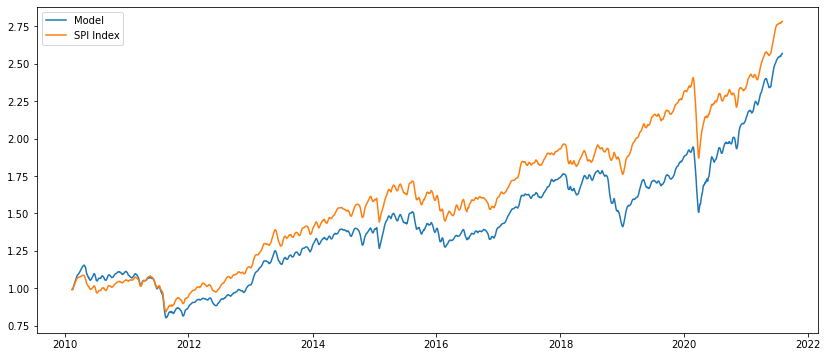

In [722]:
fig = plt.figure(figsize=(14,6))
start_date_plot = '2010-01-31'
perf_pred = pred_to_perf(df_pred[start_date_plot:]).rename('Model')
perf_bench = price_to_perf(bench_price.loc[start_date_plot:end_date])
data = pd.concat([perf_pred, perf_bench], axis=1)
                 
sns.lineplot(data=data.rolling(15).mean(), dashes=False)
plt.show()

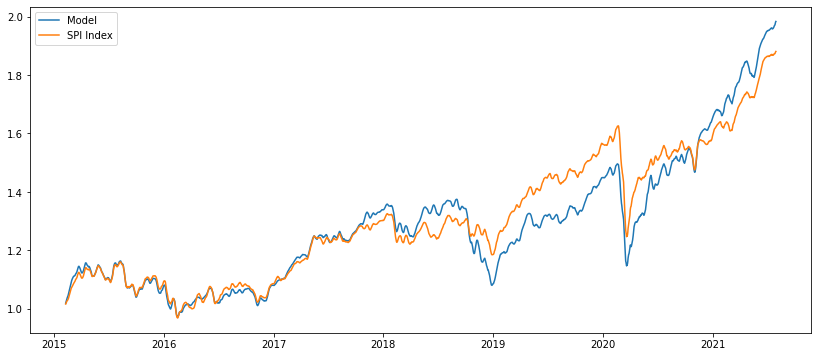

In [723]:
fig = plt.figure(figsize=(14,6))
start_date_plot = '2015-01-31'
perf_pred = pred_to_perf(df_pred[start_date_plot:]).rename('Model')
data = pd.concat([perf_pred, price_to_perf(bench_price.loc[start_date_plot:end_date])], axis=1)
                 
sns.lineplot(data=data.rolling(10).mean(), dashes=False)
plt.show()

In [663]:
X_train.shape

torch.Size([55, 4, 4, 13])

In [664]:
dim1, dim2, dim3 = X_train.size(1), X_train.size(2), X_train.size(3)
model = ConvNet(dim1, dim2, dim3, 0.2)

# criterion = nn.MSELoss()
criterion = nn.BCELoss()

eta = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=eta)
mini_batch_size = 1
nb_epochs = 100

train_accu_list = []
test_accu_list = []

train_loss_list = []
test_loss_list =[]
for e in range(nb_epochs):
    
    acc_loss = 0
    
    
    for b in range(0, X_train.size(0), mini_batch_size):
        optimizer.zero_grad()
        
        output = model(X_train.narrow(0, b, mini_batch_size))
        loss = criterion(output, y_train.narrow(0, b, mini_batch_size))
        acc_loss = acc_loss + loss.item()
        loss.backward()
        
        optimizer.step()
    
    
    if (e % 2) == 0:
        print('epoch', e + 1, ':', acc_loss)

epoch 1 : 37.69046300649643
epoch 3 : 35.70568561553955
epoch 5 : 33.19234263896942
epoch 7 : 30.461486786603928
epoch 9 : 26.618535347282887
epoch 11 : 23.308599578216672
epoch 13 : 20.730907682329416
epoch 15 : 16.309789199382067
epoch 17 : 11.553497355547734
epoch 19 : 8.60691264576326
epoch 21 : 5.467502064944711
epoch 23 : 7.530251419986598
epoch 25 : 5.524844269280038
epoch 27 : 3.0316515504091512
epoch 29 : 1.8036937879078323
epoch 31 : 2.4838610283622984
epoch 33 : 2.394421721342951
epoch 35 : 0.643574305337097
epoch 37 : 0.8401377755255908
epoch 39 : 0.7990523069524897
epoch 41 : 0.6164810997749157
epoch 43 : 1.5280483075039228
epoch 45 : 0.5212842680857648
epoch 47 : 0.3056151452249196
epoch 49 : 0.4334928653237
epoch 51 : 0.2976828504880018
epoch 53 : 0.21041655920508617
epoch 55 : 0.09164673455369154
epoch 57 : 0.11873761103578317
epoch 59 : 0.08584198222797568
epoch 61 : 0.26008424930846274
epoch 63 : 0.258602489259971
epoch 65 : 0.42533075888374583
epoch 67 : 0.1696321388

In [99]:
print('X shape', np.shape(X))
print('y shape', np.shape(y))

X shape (71, 4, 13, 4)
y shape (71, 4)


In [101]:
X_train, y_train, X_test, y_test = torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float(), torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float()

train_mean = X_train.mean(dim=[0,1,3], keepdim=True)
train_std = X_train.std(dim=[0,1,3], keepdim=True)
X_train = X_train.sub_(train_mean).div_(train_std)

test_mean = X_test.mean(dim=[0,1,3], keepdim=True)
test_std = X_test.std(dim=[0,1,3], keepdim=True)
X_test = X_test.sub_(test_mean).div_(test_std)



In [102]:
X_train.shape

torch.Size([50, 4, 13, 4])

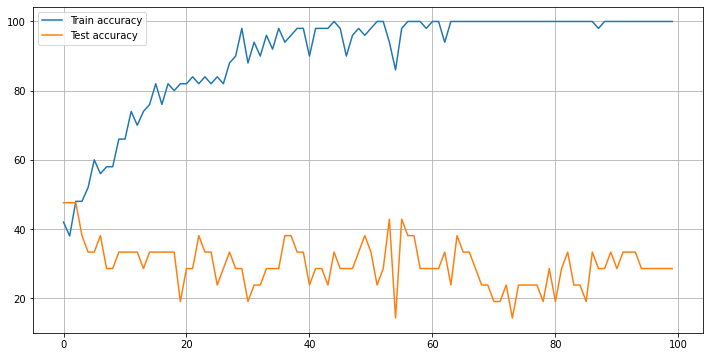

In [135]:
fig = plt.figure(figsize=(12,6))
plt.plot(list(range(nb_epochs)), train_accu_list, label='Train accuracy')
plt.plot(list(range(nb_epochs)), test_accu_list, label='Test accuracy')
plt.legend()
plt.grid()
plt.show()

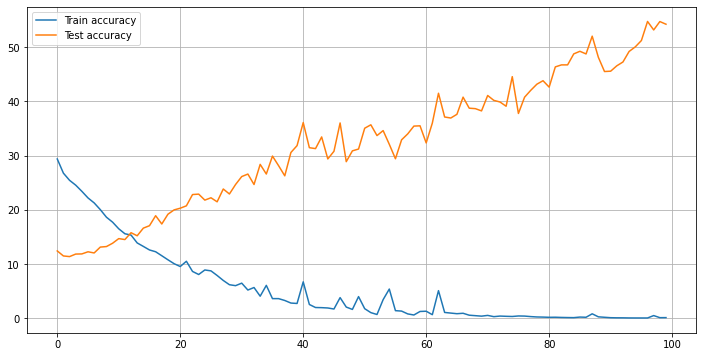

In [136]:
fig = plt.figure(figsize=(12,6))
plt.plot(list(range(nb_epochs)), train_loss_list, label='Train accuracy')
plt.plot(list(range(nb_epochs)), test_loss_list, label='Test accuracy')
plt.legend()
plt.grid()
plt.show()

In [126]:
nb_errors = 0
mini_batch_size = 1
output_list = []
prediction_train = np.zeros((X_train.size(0), y_train.size(1)))
model.eval()

for b in range(0, X_train.size(0), mini_batch_size):
    output = model(X_train.narrow(0, b, mini_batch_size))
    output_list.append(output)
    _, predicted_classes = output.max(1)
    for k in range(mini_batch_size):
        prediction_train[b, predicted_classes[k]] = 1
        if y_train[b + k, predicted_classes[k]] != 1.:
            nb_errors = nb_errors + 1
    
print('accuracy on train set: {:0.2f}%'.format(100 - (100 * nb_errors) / X_train.size(0)))

accuracy on train set: 100.00%


In [131]:
nb_errors = 0
mini_batch_size = 1
output_list = []
prediction_test = np.zeros((X_test.size(0), y_test.size(1)))
prediction_rank = []
model.eval()

for b in range(0, X_test.size(0), mini_batch_size):
    output = model(X_test.narrow(0, b, mini_batch_size))
    output_list.append(output)
    prediction_rank.append(np.array(torch.sort(output)[1]).reshape(-1))
    _, predicted_classes = output.max(1)
    for k in range(mini_batch_size):
        prediction_test[b, predicted_classes[k]] = 1
        if y_test[b + k, predicted_classes[k]] != 1.:
            nb_errors = nb_errors + 1
prediction_rank = np.array(prediction_rank)
print('accuracy on test set: {:0.2f}%'.format(100 - (100 * nb_errors) / X_test.size(0)))

accuracy on test set: 28.57%


In [134]:
fig = plt.figure(figsize=(14,6))
df_pred = pd.DataFrame(data=prediction_test, columns=price.columns, index=best_pred[split_index:].index)
split_date = str(best_pred.iloc[split_index].name)
df_results_plot = pd.concat([pred_to_perf(best_pred[split_index:]), pred_to_perf(df_pred_convnet)], axis=1).rename(columns={0:'Best prediction', 1:'ConvNet'})
sns.lineplot(data=pd.concat([df_results_plot, price_to_perf(bench_price[split_date:])], axis=1))
plt.show()

ValueError: Shape of passed values is (21, 4), indices imply (247, 4)

<Figure size 1008x432 with 0 Axes>

In [261]:
growth_rate = 0.0003
daily_vol = 0.01
mean = (pd.DataFrame(data=np.ones(len(bench_price)), index=bench_price.index, columns=['mean']) + growth_rate).cumprod()
mean

mean
1996-01-04  1.000300
1996-01-05  1.000600
1996-01-08  1.000900
1996-01-09  1.001201
1996-01-10  1.001501
...              ...
2021-10-19  7.526253
2021-10-20  7.528510
2021-10-21  7.530769
2021-10-22  7.533028
2021-10-25  7.535288

[6733 rows x 1 columns]

In [273]:
vol_forecasted = pd.DataFrame(index=bench_price.index)
vol_forecasted['vol'] = daily_vol
vol_forecasted.reset_index(inplace=True, drop=True)
vol_forecasted['t'] = vol_forecasted.index + 1
vol_forecasted['cumul_vol'] = vol_forecasted.vol * np.sqrt(vol_forecasted.t)
vol_forecasted.index = mean.index
vol_forecasted

vol     t  cumul_vol
1996-01-04  0.01     1   0.010000
1996-01-05  0.01     2   0.014142
1996-01-08  0.01     3   0.017321
1996-01-09  0.01     4   0.020000
1996-01-10  0.01     5   0.022361
...          ...   ...        ...
2021-10-19  0.01  6729   0.820305
2021-10-20  0.01  6730   0.820366
2021-10-21  0.01  6731   0.820427
2021-10-22  0.01  6732   0.820488
2021-10-25  0.01  6733   0.820549

[6733 rows x 3 columns]

In [274]:
mean['upper'] = mean['mean'] + 2 * vol_forecasted.cumul_vol
mean['lower'] = mean['mean'] - 2 * vol_forecasted.cumul_vol

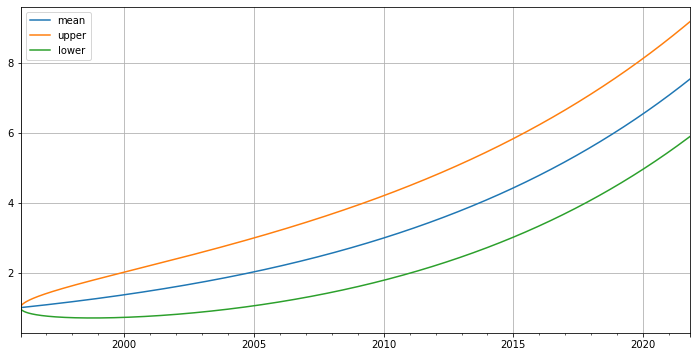

In [311]:
fig, ax = plt.subplots(figsize=(12,6))
mean.plot(ax=ax)
plt.grid()
plt.show()

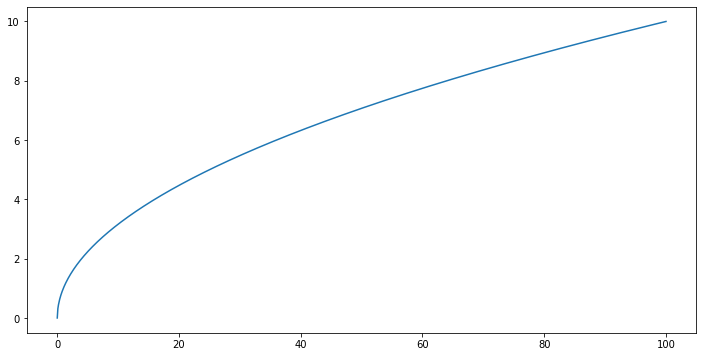

In [281]:
fig, ax = plt.subplots(figsize=(12,6))
x = np.linspace(0,100,1000)
plt.plot(x, np.sqrt(x))
plt.show()